In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

SEED = 21
plt.rcParams["figure.figsize"] = (6.4/2, 4.8/2)

### Read in the data

In [3]:
data = pd.read_pickle("../Data/GSE115978-allData.pkl")
macrophage = (data["cellType"] == "Macrophage")
data.insert(2, "macrophage", macrophage)
data

,cellID,cellType,macrophage,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,...,MIR4691,GPLD1,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,GSM3197115,Mal,False,0.0,2.067933,1.517847,0.0,1.686722,1.168448,1.526162,...,0.000000,0.367588,1.496530,0.0,0.000000,0.966075,1.876721,1.638426,1.512449,0.0
1,GSM3197116,Mal,False,0.0,1.922102,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.802701,1.909713,0.000000,0.000000,0.000000,0.0
2,GSM3197117,Mal,False,0.0,2.015497,0.841959,0.0,0.695306,0.000000,0.000000,...,0.000000,1.127459,0.000000,0.0,0.000000,0.000000,1.882266,1.141858,1.459023,0.0
3,GSM3197118,Mal,False,0.0,1.930309,1.691069,0.0,1.592092,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.947145,1.666798,1.047136,0.0
4,GSM3197119,Mal,False,0.0,2.058619,1.509809,0.0,1.748345,1.676507,1.527963,...,0.000000,0.624097,1.686261,0.0,1.601311,1.379246,1.924609,1.715210,1.352315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,GSM3204296,T.CD8,False,0.0,1.924485,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.617210,1.937055,0.0,0.000000,0.000000,1.986266,0.000000,1.991558,0.0
7182,GSM3204297,T.CD8,False,0.0,1.977320,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.636619,0.000000,0.0,1.941190,1.212302,0.000000,0.000000,1.324604,0.0
7183,GSM3204298,T.CD8,False,0.0,1.986248,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.868394,0.000000,0.0,1.997277,0.000000,0.000000,0.000000,1.601028,0.0
7184,GSM3204299,T.CD8,False,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.868568,1.488624,0.000000,0.0,0.000000,0.000000,1.668218,0.000000,1.948110,0.0


### MLP with all genes as features

#### Create Input and Output Data

In [68]:
X = data.iloc[:, 3:] # Input features
y = data["macrophage"]  # Output target

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, \
                                                  stratify=y, random_state=SEED)

#### Generate Dataset

In [7]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

#### Weighted Sampling

In [18]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

Define class weights as the reciprocal of each class count

In [19]:
class_count = torch.bincount(target_list)
class_weights = 1./class_count
class_weights

tensor([0.0002, 0.0030])

In [20]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0030, 0.0002])

In [74]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

#### Model Parameters

In [75]:
EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2

#### DataLoaders

In [76]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

#### Neural Net Architecture

In [12]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.bn_cont = nn.BatchNorm1d(num_feature, eps=1e-05, momentum=0.1, affine=True)
        self.layers = nn.Sequential(
            nn.Linear(num_feature, 100, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True),
            nn.Linear(100, 100, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True),
            nn.Linear(100, num_class, bias=True)
        )

    def forward(self, x):
        x = self.bn_cont(x)
        x = self.layers(x)
        return x


Check if GPU is active

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Create model for our task

In [79]:
model = MulticlassClassification(NUM_FEATURES, NUM_CLASSES)
model.to(device)
model

MulticlassClassification(
  (bn_cont): BatchNorm1d(21590, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21590, out_features=100, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

Set an optimizer for gradient descent and a loss function

In [21]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Train model

Function to calculate accuracy each epoch

In [24]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [82]:
print("Begin training.")

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.03144 | Val Loss: 0.05205 | Train Acc: 97.111| Val Acc: 99.096
Epoch 002: | Train Loss: 0.00264 | Val Loss: 0.07911 | Train Acc: 99.644| Val Acc: 98.470
Epoch 003: | Train Loss: 0.00189 | Val Loss: 0.05707 | Train Acc: 99.600| Val Acc: 98.540


In [83]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot: >

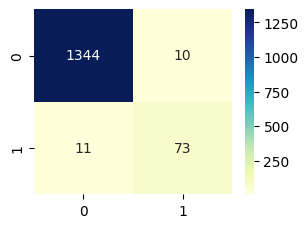

In [84]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_val, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')

In [85]:
print(classification_report(y_val, y_pred_list))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1354
        True       0.88      0.87      0.87        84

    accuracy                           0.99      1438
   macro avg       0.94      0.93      0.93      1438
weighted avg       0.99      0.99      0.99      1438



### MLP with 500 variable genes as features

In [4]:
with open("../Data/variable_genes.txt") as f:
    var_genes = f.read().splitlines()
len(var_genes)

500

#### Create Input and Output Data

In [5]:
X = data[var_genes] # Input features
y = data["macrophage"]  # Output target
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, \
                                                  stratify=y, random_state=21)

#### Generate Dataset

In [8]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

#### Weighted Sampling

Reuse code above

#### Model Parameters

In [10]:
EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = len(var_genes)
NUM_CLASSES = 2

#### DataLoaders

In [11]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

#### Initialize model

In [34]:
model = MulticlassClassification(NUM_FEATURES, NUM_CLASSES)
model.to(device)
model

MulticlassClassification(
  (bn_cont): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

#### Train model

In [35]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [36]:
print("Begin training.")

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.14264 | Val Loss: 0.15487 | Train Acc: 95.244| Val Acc: 97.218
Epoch 002: | Train Loss: 0.05606 | Val Loss: 0.11129 | Train Acc: 98.633| Val Acc: 97.914
Epoch 003: | Train Loss: 0.04085 | Val Loss: 0.08932 | Train Acc: 98.922| Val Acc: 98.401


#### Metrics

In [37]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot: >

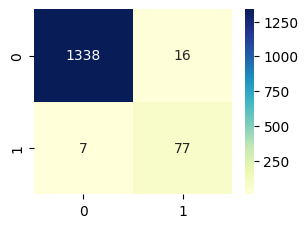

In [38]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_val, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')

In [39]:
print(classification_report(y_val, y_pred_list))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1354
        True       0.83      0.92      0.87        84

    accuracy                           0.98      1438
   macro avg       0.91      0.95      0.93      1438
weighted avg       0.99      0.98      0.98      1438

